In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import networkit as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import phate

from scipy import sparse

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from IPython.display import display, Math, Latex, Markdown
from tqdm.notebook import tqdm

from External.ICT.calculate_ICT import calculate_ICT, calculate_sub_ICTs
from External.clustering import centers, k_means_pp
from External.generation import create_graph
from External.plotting import plot_points, plot_graph, no_intersections
from External.create_k_nearest import patch_together

plt.style.use('standard.mplstyle')

In [5]:
# Hyperparameters
mode = "K_Nearest"
metric = "euclidean"
dataset = "non_convex"
ICT_algorithm = "cluster_all"


# image loading
n = number_of_nodes = 2000
Random = False
image_name = "image"

In [6]:
def load_image(filename):
    a=plt.imread(filename+'.png')
    rgb_weights = [0.2989, 0.5870, 0.1140]
    
    grayscale_image = np.dot(a[...,:3], rgb_weights)>0
    
    return grayscale_image
    
    
def sample_points_from_image(n,img,Random=True):
    if not Random:
        random.seed(42)
    non_zero = np.where(img!=0)
    # non_zero=np.vstack((non_zero[0],non_zero[1])).T
    
    
    idx = random.sample(range(len(non_zero[0])),n)
    
    x_coord = non_zero[0][idx]
    y_coord = non_zero[1][idx]
    return x_coord,y_coord

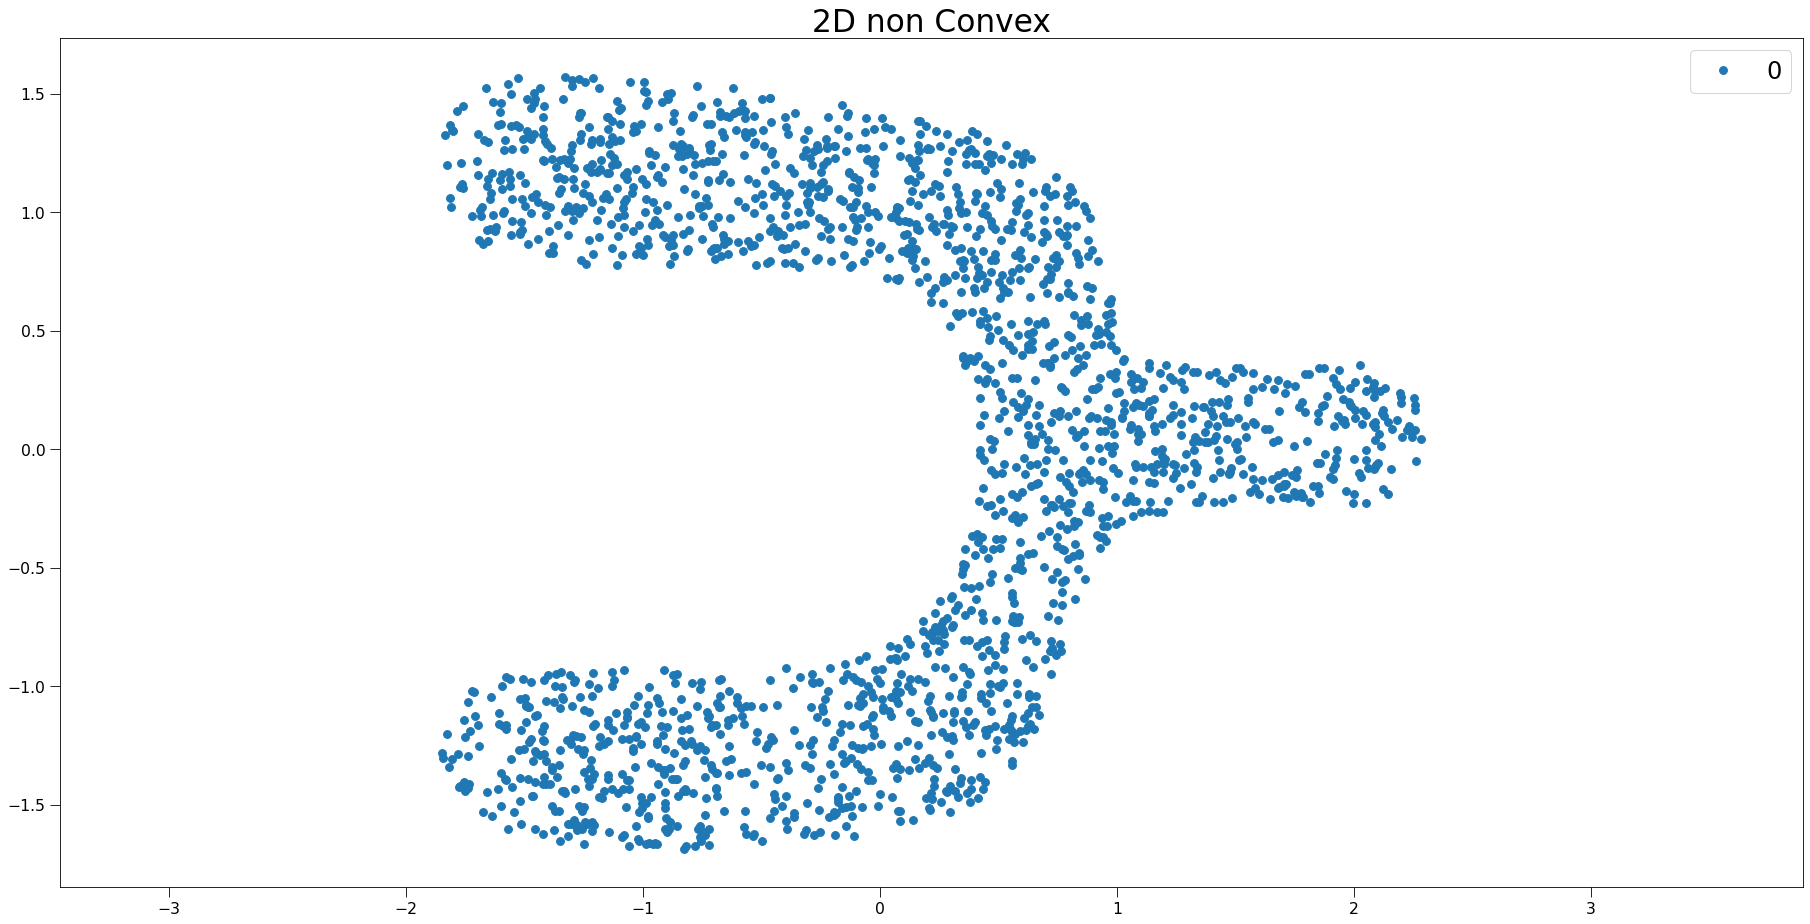

In [7]:
# Compute the position array
img = load_image(image_name)
position = np.array(sample_points_from_image(n,img,Random)).T
position = StandardScaler().fit_transform(position)

fig, ax = plt.subplots(1)
plot_points(position, f"2D non Convex", ax)

In [8]:
d = pairwise_distances(position)
d[d==0] = np.inf
min_distance = np.min(d, axis=0)
avg_distance = np.mean(min_distance)

dims = position.shape[-1]
radius = 0.1 * avg_distance
# radius = 0.7 * avg_distance
a = radius * (2 / np.sqrt(dims))*0.9

In [9]:
borders = [[] for _ in range(dims)]

for i in range(dims):
    p = position[...,i]
    r = np.min(p)
    s = np.max(p)
    borders[i] = [r, s, ((s-r) // a) + 1 , a]
    borders[i][0] -= 1/2 * borders[i][3]
    borders[i][1] += 3/2 * borders[i][3]
    borders[i][2] += 2
    
borders = np.array(borders) 

centers = []

for x in borders[0][0] + (np.arange(borders[0][2])) * borders[1][3]:
    for y in borders[1][0] + (np.arange(borders[1][2])) * borders[1][3]:
        centers.append([x,y])
        
centers = np.array(centers)

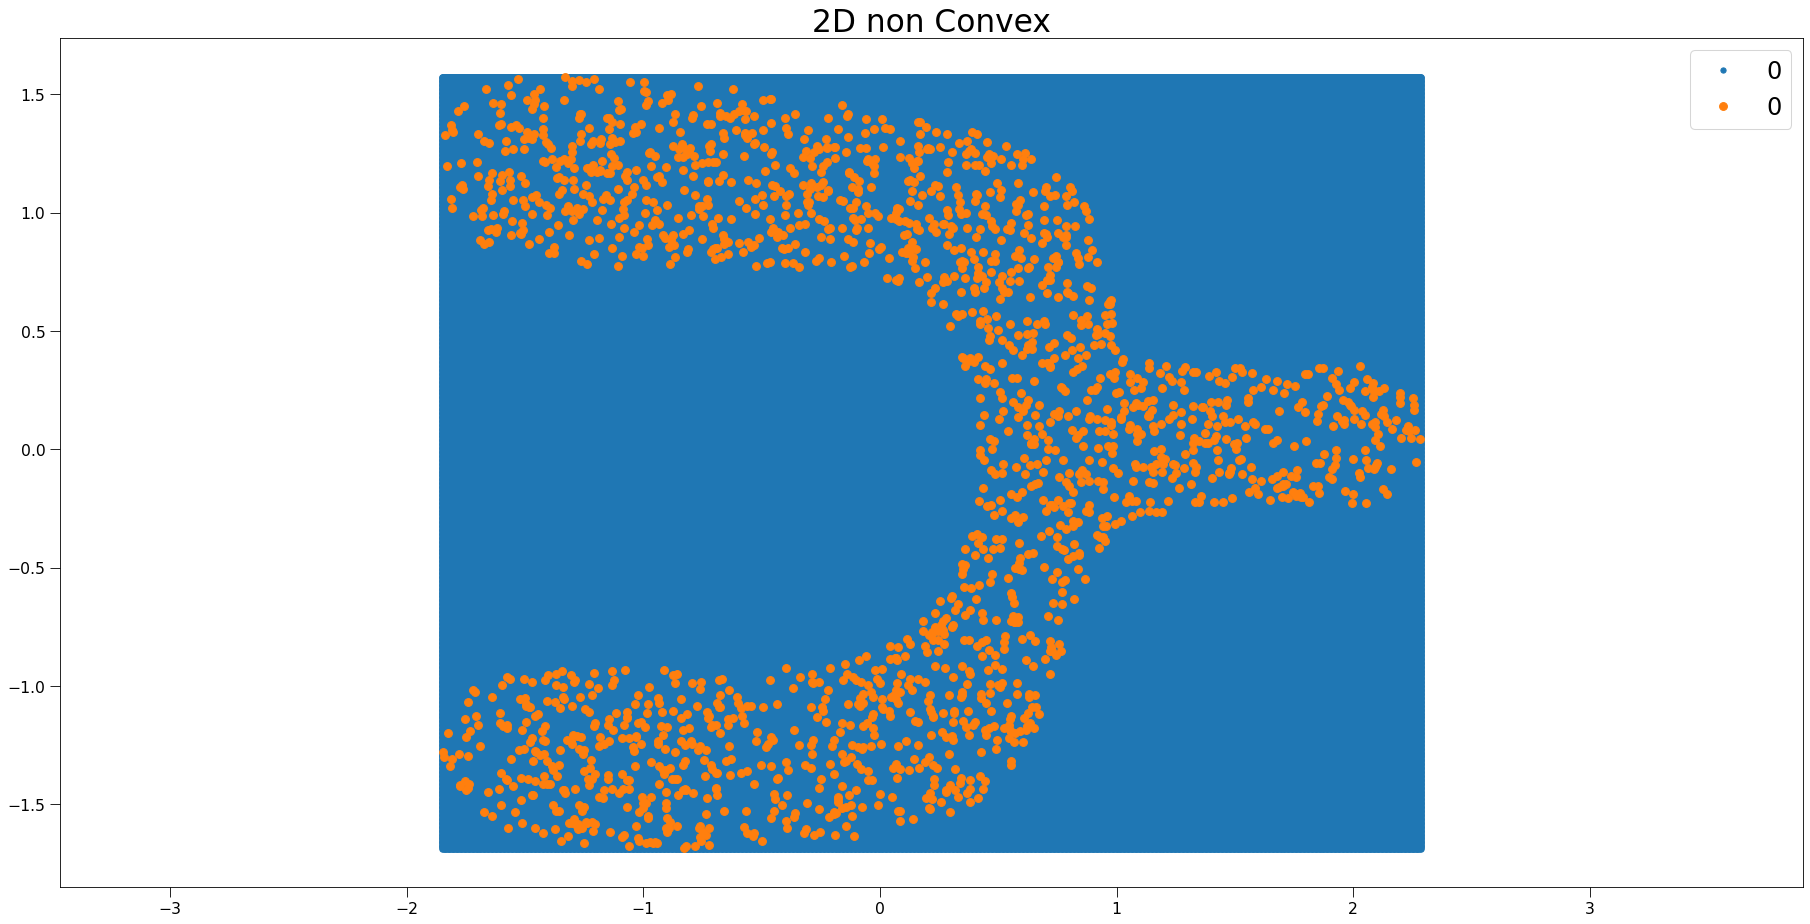

In [10]:
fig, ax = plt.subplots(1)
plot_points(centers, f"2D non Convex", ax, node_size=10)
plot_points(position, f"2D non Convex", ax)

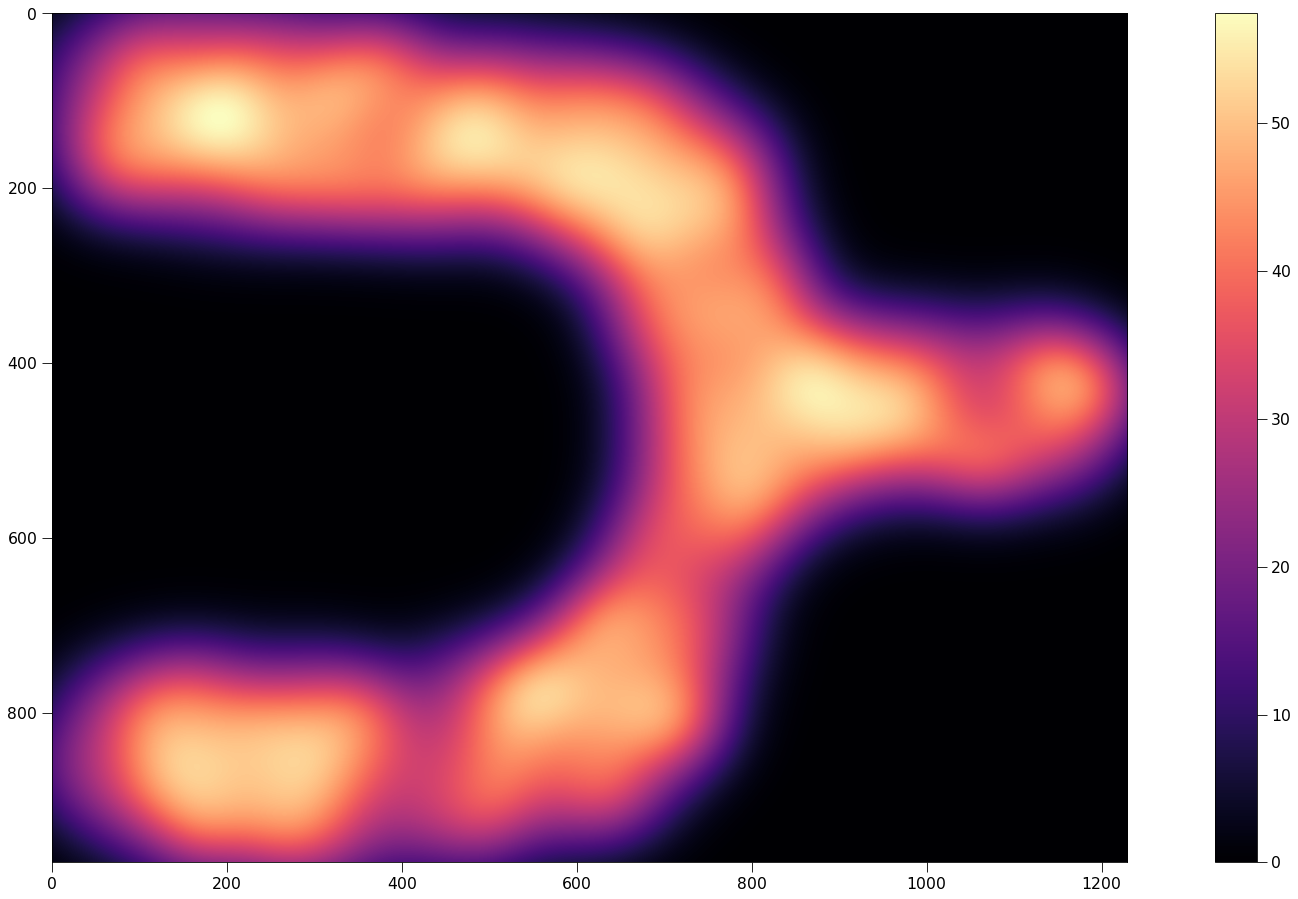

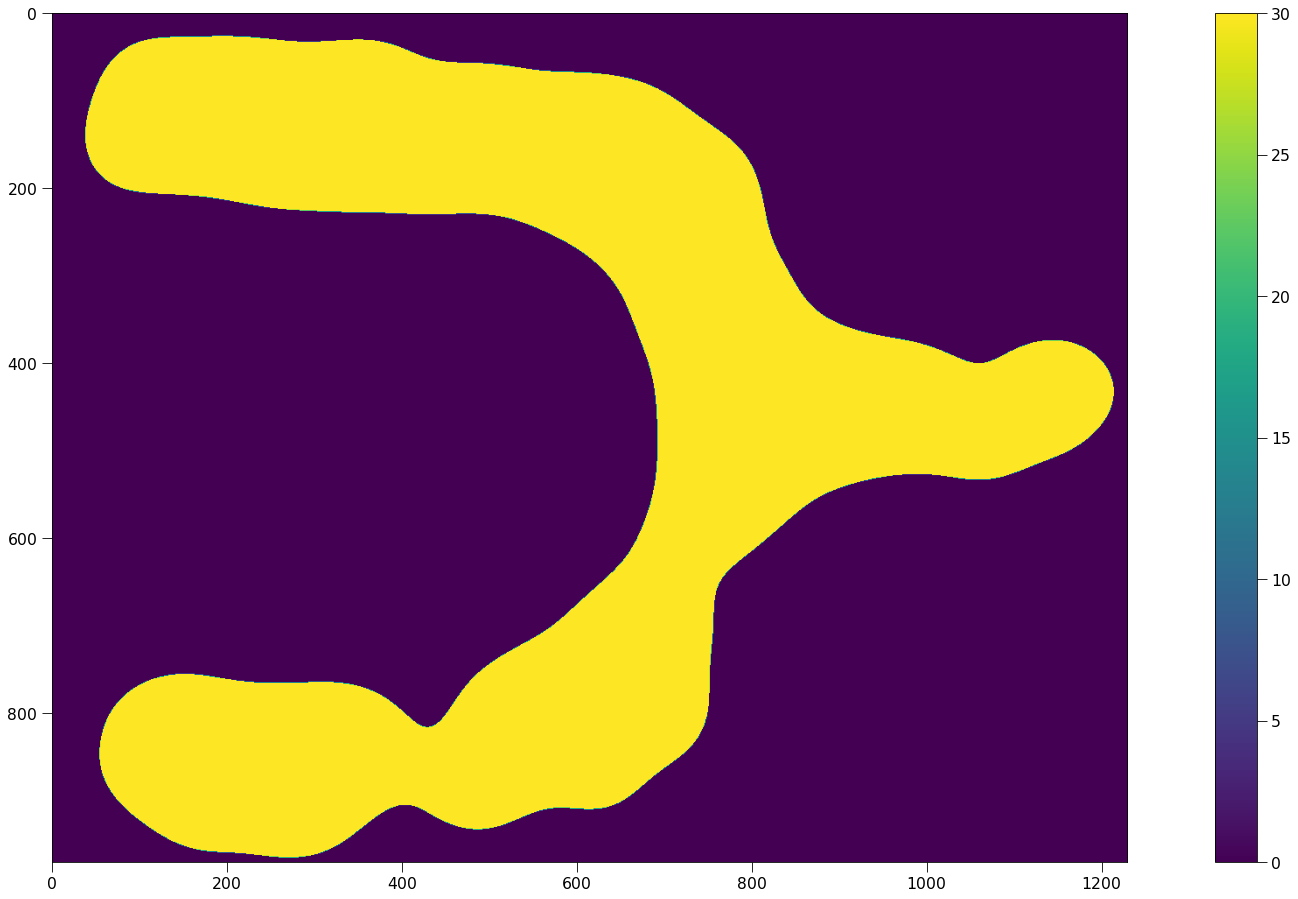

In [11]:
g = np.zeros(shape=borders.T[2].astype(int))

distances = pairwise_distances(centers.reshape(-1,2), position)

g = np.sum(np.exp(-distances**2 * 25), axis=1).reshape(g.shape)


plt.imshow(g.T[::-1], cmap="magma")
plt.colorbar()
plt.show()

g[g>30] = 30
g[g<30] = 0

plt.imshow(g.T[::-1])
plt.colorbar()
plt.show()